In [7]:
import os
import sys

sys.path.append("/home/yuri/github.com/AoesJP/project_pokereader")
sys.path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/yuri/code/teddy8193/gcp/project-poke-reader-03f0247650f8.json"

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pickle
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev
from pokedex.edges import deformer, draw

In [10]:
from google.cloud import storage

client = storage.Client()
client

In [11]:
PROJECT_PATH = Path(".").absolute().parent.parent
DATA_PATH = PROJECT_PATH / "data"
DATA_PATH

PosixPath('/home/yuri/github.com/AoesJP/project_pokereader/data')

In [33]:
CLEAN_CARDS_PATH = DATA_PATH / "clean_cards"
CLEAN_CARDS_PATH

PosixPath('/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards')

In [14]:
bucket_name = "pokedex_data"
bucket = client.get_bucket(bucket_name)
bucket

<Bucket: pokedex_data>

In [31]:
# for blob in client.list_blobs(bucket_name, prefix="pokemon_cards_api"):
#     file_name = blob.name.split("/")[-1]
#     set_name = blob.name.split("/")[-1].split("_")[1]
#     if not Path(DATA_PATH / "clean_cards" / set_name).exists():
#         Path(DATA_PATH / "clean_cards" / set_name).mkdir(parents=True)
#     blob.download_to_filename(str(DATA_PATH / f"clean_cards/{set_name}/{file_name}"))

In [55]:
files = []
for a in CLEAN_CARDS_PATH.glob("*/*"):
    files.append(str(a.absolute()))

['/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_63.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_147.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_182.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_144.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_21.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_184.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_132.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_190.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_44.png',
 '/home/yuri/github.com/AoesJP/project_pokereader/data/clean_cards/sv3pt5/card_sv3pt5_5.png',
 '/home/yuri/github.com/AoesJP/project_pokere

In [219]:
def make_contour(img: np.ndarray, blur=1, shift=3):
    _ = deformer.apply_blur(img, shift=blur)
    _ = deformer.mono_grad(_, shift)
    _ = cv2.cvtColor(_, cv2.COLOR_RGB2GRAY)
    return _

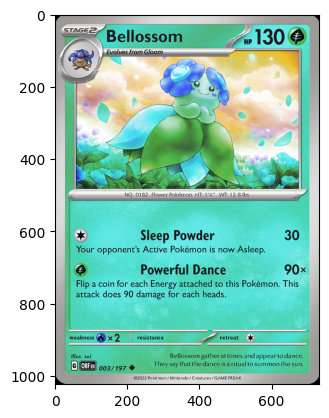

In [40]:
img = cv2.imread(str(CLEAN_CARDS_PATH / "sv3" / "card_sv3_3.png"))
draw.show_color(img)

In [103]:
len(files)

3032

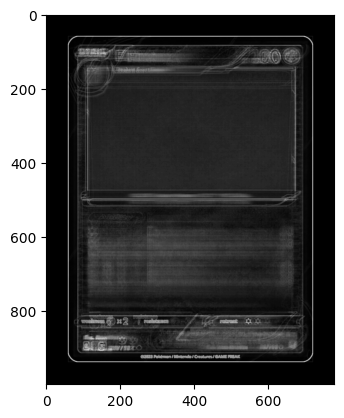

In [105]:
# cnt = None
# N = 3000
# for file in files[:N]:
#     img = (cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)).astype("float32") / 255
#     img = cv2.resize(img, (660, 880))
#     b = 60
#     a = cv2.copyMakeBorder(img, b, b, b, b, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#     if cnt is None:
#         cnt = make_contour(a).astype("float32")
#     else:
#         cnt += make_contour(a).astype("float32")

# cnt = (cnt / N) * 255
# draw.show_grey(cnt)

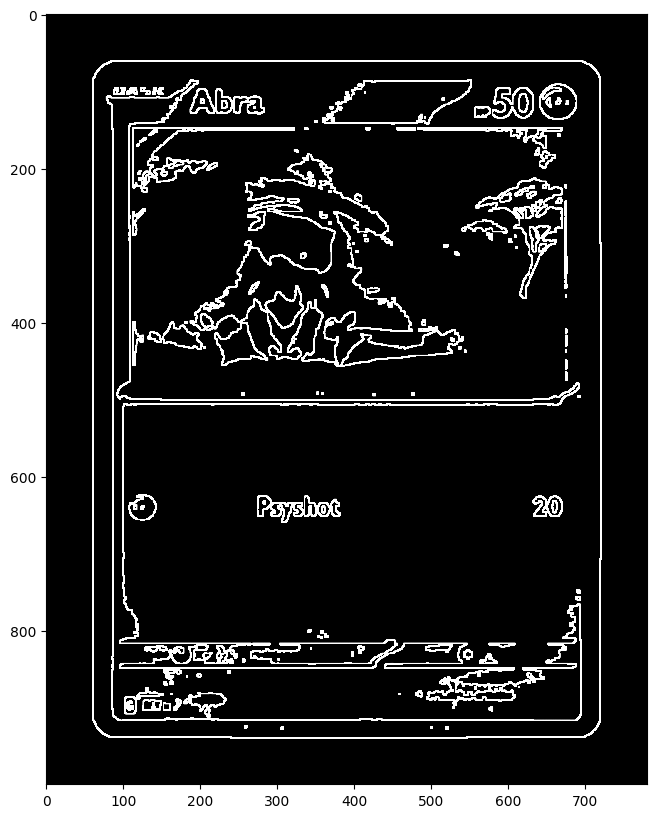

In [276]:
cnt = None
N = 1
for file in files[:N]:
    img = (cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)).astype("float32") / 255
    img = cv2.resize(img, (660, 880))
    b = 60
    a = cv2.copyMakeBorder(img, b, b, b, b, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    a = cv2.GaussianBlur(a, ksize=(5, 5), sigmaX=0)
    a = make_contour(a, 3, 2)
    # ret3, th3 = cv2.threshold(target_cnt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    a = cv2.adaptiveThreshold(a, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 71, 0)

    result = a.astype("float32")
    if cnt is None:
        cnt = result
    else:
        cnt += result

cnt = (cnt / N) * 255
draw.show_grey(cnt)

In [269]:
a.max()

255

In [108]:
# with open(DATA_PATH / "cnt_avg_all.pickle", mode="wb") as f:
#     pickle.dump(cnt, f)

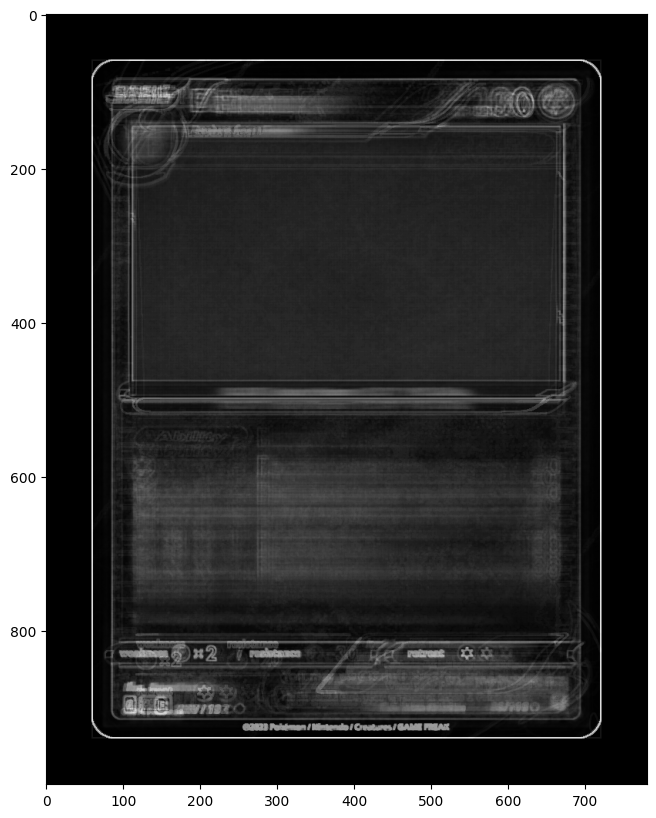

In [372]:
with open(DATA_PATH / "cnt_avg_all.pickle", mode="rb") as f:
    cnt = pickle.load(f)

draw.show_grey(cnt)

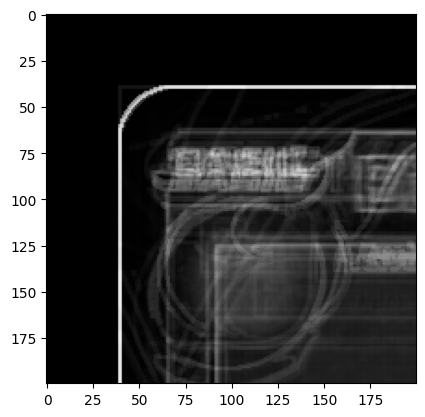

In [143]:
k_size = 200
p = 20
w = cnt.shape[1]
h = cnt.shape[0]
kernel_tl = cnt[p : k_size + p, p : k_size + p]
kernel_tr = cnt[p : k_size + p, 2 - k_size - p : 2 - p]
kernel_bl = cnt[2 - k_size - p : 2 - p, p : k_size + p]
kernel_br = cnt[2 - k_size - p : 2 - p, 2 - k_size - p : 2 - p]
kernels = {"tl": kernel_tl, "tr": kernel_tr, "bl": kernel_bl, "br": kernel_br}
draw.show_grey(kernel_tl)

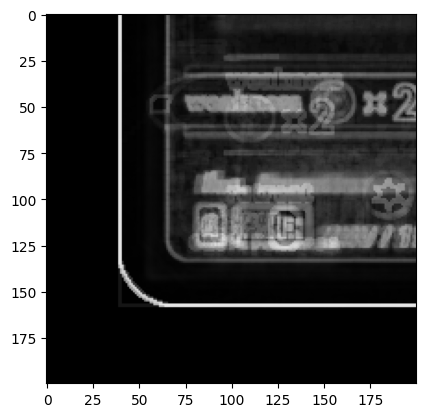

In [166]:
draw.show_grey(kernel_bl)

In [144]:
# for name, kernel in kernels.items():
#     with open(DATA_PATH / f"cnt_{name}.pickle", mode="wb") as f:
#         pickle.dump(kernel, f)

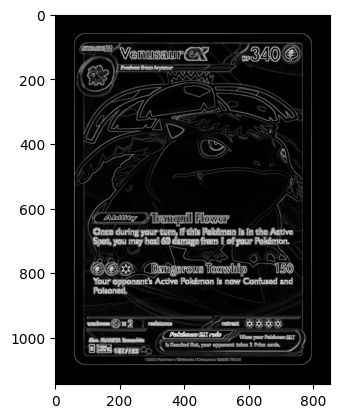

In [73]:
draw.show_grey(make_contour(a))

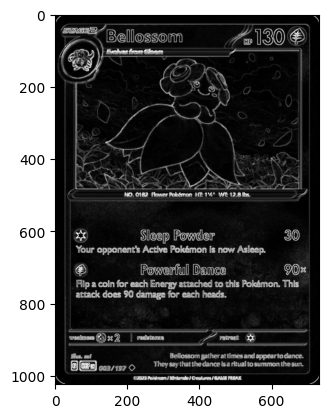

In [41]:
_ = deformer.apply_blur(img, shift=1)
_ = deformer.mono_grad(_, 3)
_ = cv2.cvtColor(_, cv2.COLOR_RGB2GRAY)
draw.show_grey(_)

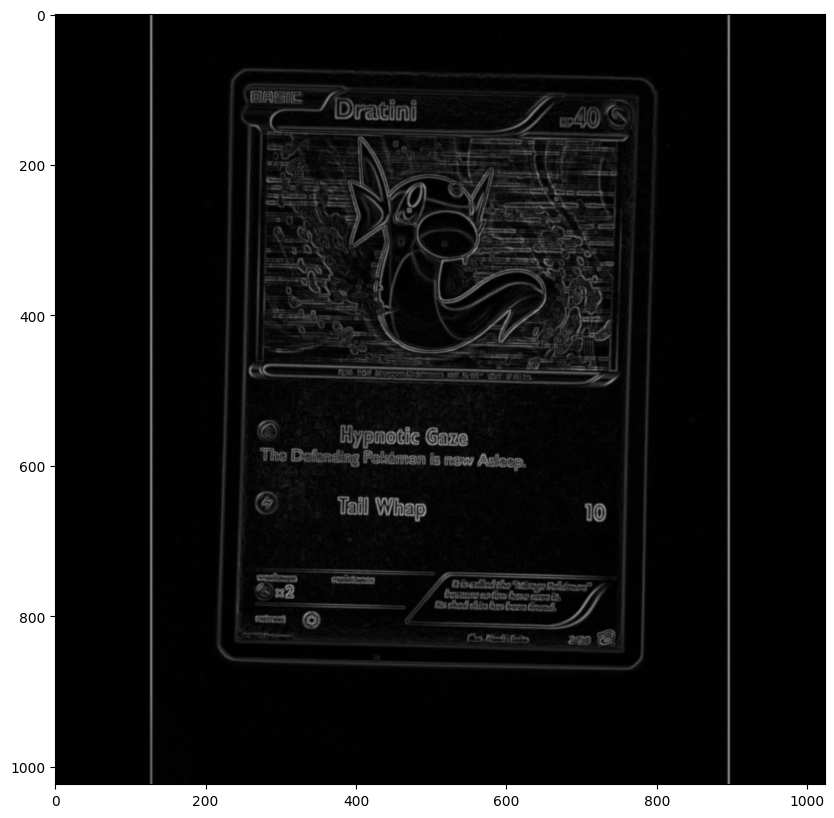

In [373]:
img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/dv1-2.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/pika.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/charizard2.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/swsh6-16_2.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke2.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke1.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/IMG_1460.jpeg"
img_test = cv2.imread(img_path)
# img_test = deformer.resize_with_fill(img_test, 1024, 1024)
img_test = deformer.resize_with_fill(img_test, 1024, 1024)
img_test = cv2.GaussianBlur(img_test, ksize=(5, 5), sigmaX=0)
target_cnt = make_contour(img_test, 1, 3)
# ret3, th3 = cv2.threshold(target_cnt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# th3 = cv2.adaptiveThreshold(target_cnt, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 71, 0)
# kernel = np.ones((3, 3), np.uint8)
# th3 = cv2.erode(th3, kernel, iterations=1)
# kernel = np.ones((1, 1), np.uint8)
# th3 = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)

# lines = cv2.HoughLines(th3, 5, np.pi / 180, 1200, lines=10)
# img_copy = img_test.copy()
# for line in lines:
#     for rho, theta in line:
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         x1 = int(x0 + 1000 * (-b))
#         y1 = int(y0 + 1000 * (a))
#         x2 = int(x0 - 1000 * (-b))
#         y2 = int(y0 - 1000 * (a))

#     cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 255), 2)


# draw.show_color(img_copy)
# draw.show_grey(th3)
draw.show_grey(target_cnt)

In [379]:
target_cnt.astype("uint8").shape

(1024, 1024)

In [377]:
cnt.astype("uint8").shape

(1000, 780)

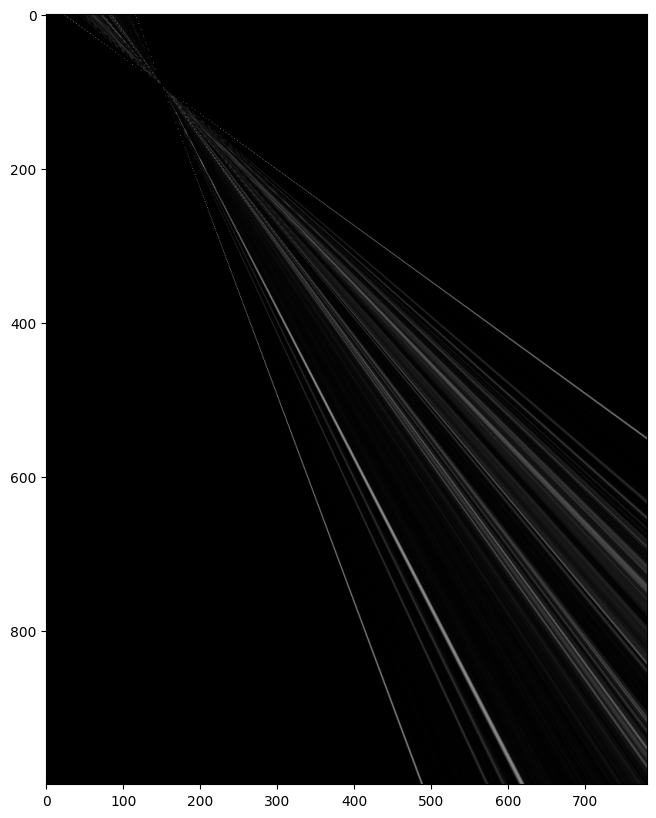

In [389]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15


def alignImages(im1, im2):
    # Convert images to grayscale
    # im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    # im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    im1Gray = im1
    im2Gray = im2

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h


imReg, h = alignImages(target_cnt.astype("uint8"), cnt.astype("uint8"))
draw.show_grey(imReg)

In [156]:
target_cnt.dtype

dtype('uint8')

In [157]:
kernel_tl.dtype

dtype('float32')

(0.0512731671333313, 0.6019337773323059, (824, 121), (193, 127))

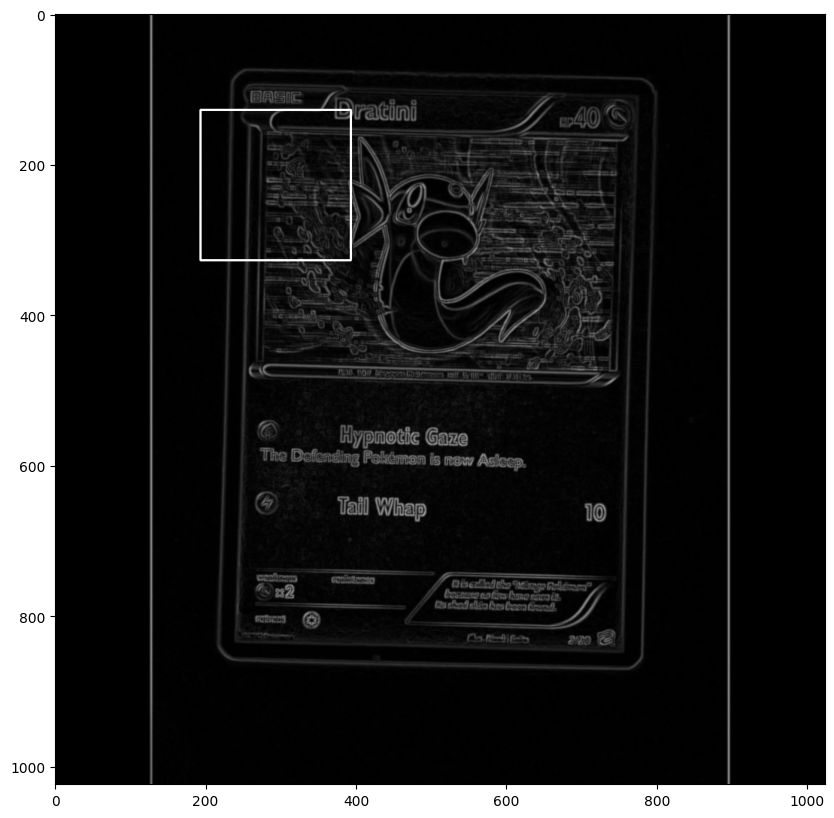

In [370]:
target = kernel_bl
w, h = target.shape

# 画像の検索（Template Matching）
result = cv2.matchTemplate(target_cnt, target.astype("uint8"), cv2.TM_CCORR_NORMED)
# 検索結果の信頼度と位置座標の取得
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
cv2.minMaxLoc(result)

top_left = max_loc

# 検索結果の右下頂点の座標を取得
bottom_right = (top_left[0] + w, top_left[1] + h)
img_copy = target_cnt.copy()
# 検索対象画像内に、検索結果を長方形で描画
cv2.rectangle(img_copy, top_left, bottom_right, (255, 255, 0), 2)
draw.show_grey(img_copy)

cv2.minMaxLoc(result)

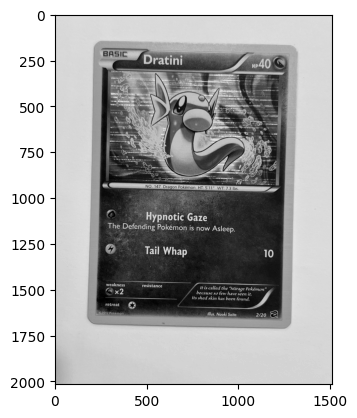

In [186]:
img_path2 = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/dv1-2.jpg"
img_test2 = cv2.imread(img_path2)
h, w = img_test2.shape[:2]
img_test2 = cv2.resize(img_test2, (int(w * 0.5), int(h * 0.5)))
img_test2 = cv2.cvtColor(img_test2, cv2.COLOR_BGR2GRAY)
draw.show_grey(img_test2)

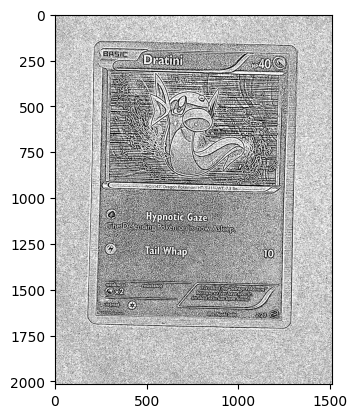

In [187]:
th3 = cv2.adaptiveThreshold(img_test2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
draw.show_grey(th3)

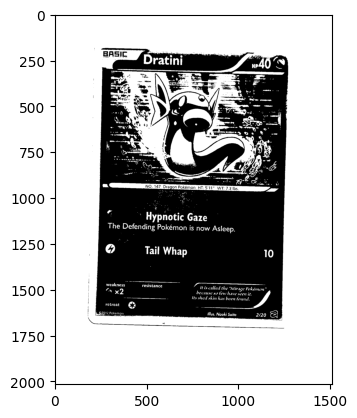

In [191]:
blur = cv2.GaussianBlur(img_test2, (5, 5), 0)
ret3, th3 = cv2.threshold(img_test2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
draw.show_grey(th3)